## Ecuación de Advección con condiciones de borde usando diferencias finitas y el método de líneas

### Oscar Reula, Pablo Montes, Joaquín Pelle

Resolveremos la ecuación de advección usando el *método de líneas* y *diferencias finitas*. A su vez, puesto que habrá condiciones de borde no periódicas, utilizaremos ***métodos de penalización (penalty methods)*** para imponer los valores de los campos en las fronteras.

Resolveremos la ecuación de advección

\begin{equation}
u_t = -c u_x
\end{equation}

Asumimos que $c>0$, de manera tal que la onda se propague hacia la derecha con velocidad $c$. Resolveremos esta ecuación en el intervalo espacial $[0, L]$. Notemos que, puesto que la solución viaja hacia la derecha, solo necesitamos dar valores de contorno a la izquierda; esto es, en el punto $x=0$.

Por ejemplo, mostramos a continuación la solución exacta de la ecuación de advección para dato inicial $u(x,0) = 0$ y $u(0,t) = \sin(t)$ en el intervalo espacial $[0, 2\pi]$.

In [ ]:
using Plots
N = 1001
L = 2.0*π
dx = L/(N-1)
x = [dx * (i-1) for i in 1:N] #valores espaciales
tiempos = range(0, 20, length = 400)              #valores temporales
c = 1.0  #velocidad de advección. Puede cambiarla a cualquier valor mayor que 0.

function u_0(x)
    #puede cambiar esto por el dato inicial que quiera
    return 0
end

function g(t)
   #condición de borde en x = 0. Puede cambiarla por la función que quiera. Idealmente,
   #trate de que se cumpla g(t=0) = u_0(x=0)
   return sin(t) 
end

function solution(x, t)
    if x > c*t
        return u_0(c*t-x)
    else
        return g(t-x/c)
    end
end

anim = @animate for t in tiempos
    p1 = plot(x, solution.(x, t), ylim = (-1.1, 1.1),
        xlabel = "\$x\$", label = "solución exacta", legendfontsize = 10,
    ylabel = "\$u\$")
    title!(p1, "Ecuación de advección")
    
    plot(p1, size=(600,400))
end
gif(anim, "Ejemplo_Adveccion.gif", fps = 30)

Representaremos el intervalo $[0,2\pi]$ con una grilla de $N$ puntos, $P_N = \{(i-1)\Delta x : i = 1,...,N \,, \; \Delta x= 2\pi/(N-1)  \}$. Luego, si $I \subset \mathbb{R}$ es un intervalo de tiempo, la discretización espacial de la solución $u \colon [0,2\pi] \times I \to \mathbb{R}$ tendrá la forma $v \colon P_N \times I \to \mathbb{R}$, o equivalentemente $v \colon I \to \mathbb{R}^N$ (es decir, un vector de grilla a cada instante). Además, aproximaremos la derivada espacial con un operador de diferencias finitas $D_x \colon \mathbb{R}^N \to \mathbb{R}^N$, obteniendo el sistema de EDOs

\begin{equation}
v_t = -c D_x v.
\end{equation}

Note que, a diferencia del práctico anterior, el operador $D_x$ no será periódico. Finalmente, procederemos a aproximar el sistema de EDOs utilizando un integrador adecuado. De esta forma obtendremos un sistema discretizado tanto en tiempo como en espacio.

Ahora definimos los esquemas de diferencias finitas. Están implementados como matrices que multiplican los vectores de la solución. Las matrices están definidas como dispersas para mayor eficiencia computacional.
Haremos primero el mátodo de segundo orden ya que es más simple. En lugar del operador que usamos para el caso periódico, utilizaremos operadores de diferencias finitas que satisfagan ***suma por partes***, llamados **SBP** por **S**ummation **B**y **P**arts.

Estos operadores satisfacen propiedades análogas a las derivadas al ser integradas. En particular, la propiedad

$$
\int_a^b \left [u(x) \frac{dv(x)}{dx} + \frac{du(x)}{dx} v(x) \right]\; dx = v(b)u(b) - v(a)u(a)
$$

corresponde a nivel discreto a

$$
\sum_{ij} h^{ij}[u_i (Dv)_j + (Du)_i v_j] = u[N]v[N] - u[1]v[1]\,,
$$


donde la forma $h$ define un producto interno, que será nuestra versión discreta del producto interno $<u,v> = \int uv dx$. Para aproximaciones de segundo y cuarto orden existe un único par $(h, D)$ con $h$ diagonal, tal que se satisface la propiedad, pero para mayor orden hay más grados de libertad. $h$ puede ser una forma bilineal diagonal o más complicada. Esto puede ser importante para problemas en varias dimensiones, pero por el momento nos restringiremos a formas $h$ diagonales.

### Un momento, ¿por qué queremos esa propiedad?
Supongamos que tenemos la ecuación de advección en el intervalo $[a,b]$. Podemos definir una energía de la solución como

$$E(t) = \dfrac{1}{2}\int_{a}^{b} u(t,x)^{2}dx.$$

Esta energía cumple que $E(t) > 0 \;\forall t$ y que 

\begin{align}
\dfrac{dE}{dt} &= \dfrac{d}{dt} \dfrac{1}{2}\int_{a}^{b} u(t,x)^{2}dx\\
&= \int \dfrac{\partial u(t,x)}{\partial t}u(x,t)dx\\
&= -\int c\dfrac{\partial u(t,x)}{\partial x}u(x,t)dx\\
&= -\int \frac{c}{2}\dfrac{\partial u(t,x)^2}{\partial x}\;dx\\
&= \dfrac{c}{2} \left( u(a,t)^{2} - u(b,t)^{2} \right )\\
\end{align}

donde hemos utilizado la ecuación de advección para pasar de una derivada temporal a una derivada espacial. En el caso periódico, $u(a,t) = u(b,t)$, y $\dfrac{dE}{dt} = 0$. En caso contrario, la tasa de cambio de la energía depende únicamente de lo que sucede en los bordes del dominio, es decir, de *cuánta energía sale y cuánta energía entra* por los bordes.

Cuando discretizamos espacialmente, quermos poder garantizar que esta clase de relaciones se mantengan o  que, en el peor de los casos, la energía no crezca en problemas donde debería mantenerse constante.
Tratemos de repetir los pasos para la ecuación semidiscreta. Ahora,
$$
E(t) = \dfrac{1}{2}\sum_{ij}h_{ij}u_{i}(t)u_{j}(t) \Delta x 
$$
y la derivada temporal cumplirá
\begin{align}
\dfrac{dE}{dt} &= \dfrac{d}{dt} \dfrac{1}{2}\sum_{ij}h_{ij}u_{i}(t)u_{j}(t) \Delta x \\
&= \dfrac{1}{2}\sum_{ij}h_{ij}\left(\dfrac{du_{i}}{dt}(t)u_{j}(t) + \dfrac{du_{j}}{dt}(t)u_{i}(t)\right) \Delta x \\
&= - \dfrac{c}{2}\sum_{ij}h_{ij} \left((Du)_{i}(t)u_{j}(t) + (Du)_{j}(t)u_{i}(t)\right) \Delta x\\
\end{align}

y, en principio, no podemos avanzar mas allá de este punto. La propiedad de suma por partes nos deja ir un paso mas allá, y nos permite llegar a
$$
\dfrac{dE}{dt} = \frac{c}{2}\left(u_1^{2} - u_N^{2}\right ) \leq \frac{c}{2}u_1^{2}.
$$

### Operador SBP de segundo orden

Estamos usando Julia, por lo que cargaremos algunos paquetes para manejar matrices, resolver EDOs y graficar.

In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
using BandedMatrices
using SparseArrays

In [2]:
function create_D_2_sbp(N)
    D_2_sbp = Tridiagonal([-0.5 for i in 1:N-1],[0.0 for i in 1:N],[0.5 for i in 1:N-1])
    D_2_sbp[1,1] = -1.0
    D_2_sbp[1,2] = 1.0
    D_2_sbp[end,end] = 1.0
    D_2_sbp[end,end-1] = -1.0
    h2 = Diagonal([1. for i in 1:N])
    h2[1,1] = 0.5
    h2[N,N] = 0.5
    return h2, D_2_sbp
end

create_D_2_sbp (generic function with 1 method)

In [3]:
h2, D_2_sbp = create_D_2_sbp(8);
#Matriz del producto interno H
display(h2)
#Operador de derivada de segundo orden en el interior, primer orden en el borde
display(D_2_sbp)

8×8 Diagonal{Float64, Vector{Float64}}:
 0.5   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   0.5

8×8 Tridiagonal{Float64, Vector{Float64}}:
 -1.0   1.0    ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
 -0.5   0.0   0.5    ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅   -0.5   0.0   0.5    ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅   -0.5   0.0   0.5    ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅   -0.5   0.0   0.5    ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.5   0.0   0.5   ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.5   0.0  0.5
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0  1.0

Podemos chequear que la condición de suma por partes se cumpla. Recordemos que queremos que
$$
\sum_{ij} h^{ij}[u_i (Dv)_j + (Du)_i v_j] = u[N]v[N] - u[1]v[1],
$$
o, lo que es lo mismo
$$
(hDv)^{T}u + (hDu)^{T}v = u[N]v[N] - u[1]v[1]
$$
para todo $u$ y para todo $v$.

In [4]:
N = 400
h2, D_2_sbp = create_D_2_sbp(N);
u = rand(N) #Definimos algun u completamente aleatorio
v = rand(N) #Definimos algún v completamente aleatorio
#h(Dv)'u 
println("El siguiente número debe ser 0 (o un número ridículamente pequeño, cercano a 10^-16)")
println((h2 * (D_2_sbp * v))' * u +  (h2 * (D_2_sbp * u))' * v - (u[N]*v[N] - u[1]*v[1]))

El siguiente número debe ser 0 (o un número ridículamente pequeño, cercano a 10^-16)
-5.273559366969494e-16


### Condición de borde

Agregaremos la condición de borde en $x=0$ a través de un término de penalización en el lado derecho de la ecuación de advección. Esta clase de términos se llaman **SAT** por sus siglas en inglés ***Simulteneous Approximation Terms*** *(Términos de Aproximación Simultánea)*.

\begin{equation}
(u_t)_i = -c (D_x\; u)_i + \delta_{i1} \textrm{SAT}_1 + \delta_{iN} \textrm{SAT}_N.
\end{equation}

En este caso, $\textrm{SAT}_N = 0$ dado que no necesitamos dar condición de borde a la izquierda, mientras que $\textrm{SAT}_1$ cumple

$$
\textrm{SAT}_1 = \frac{c}{h_{11}\Delta x}(g(t) - u_1)
$$

donde $g(t)$ es la condición de borde que queremos imponer. Note que esta ecuación es una fuente agregada al primer punto de grilla que lo fuerza a decaer exponencialmente hacia la solución $g(t)$.

### Conservación de Energía

Repitamos la cuenta para ver cómo se comporta la energía del sistema

\begin{align}
\dfrac{dE}{dt} &= \dfrac{d}{dt} \dfrac{1}{2}\sum_{ij}h_{ij}u_{i}(t)u_{j}(t) \Delta x \\
&= \dfrac{1}{2}\sum_{ij}h_{ij}\left(\dfrac{du_{i}}{dt}(t)u_{j}(t) + \dfrac{du_{j}}{dt}(t)u_{i}(t)\right) \Delta x \\
&= - \dfrac{c}{2}\sum_{ij}h_{ij} \left((Du)_{i}(t)u_{j}(t) + (Du)_{j}(t)u_{i}(t)\right) \Delta x \\
&\quad+ \dfrac{c}{h_{11}\Delta x}\dfrac{1}{2}\sum_{ij}h_{ij} \left( \delta_{i1} (g(t)-u_1)u_j + \delta_{j1} (g(t)-u_1)u_i \right )\Delta x\\
&= \frac{c}{2} \left ( u_1(t)^{2}-u_N(t)^{2} \right ) + c\left (g(t)u_1(t) - u_1(t)^{2}\right)\\
&= \frac{c}{2}\left ( g(t)^{2} - (u_1(t) - g(t)) ^2 - u_2(t)^{2} \right )\\
&\leq \frac{c}{2} \left( g(t)^2 - u_2(t)^{2}\right )\\
&\leq \frac{c}{2} g(t)^2
\end{align}

donde hemos utilizado que $h_{ij}$ es diagonal. Este resultado es consistente con la ecuación original y puede utilizarse para demostrar estabilidad de la solución. Podemos ver que la derivada temporal de la energía del sistema semidiscreto es menor o igual a la del sistema original.

También podemos ver que la ecuación original satisface la ley de conservación

$$
\dfrac{d}{dt}\int_{a}^{b}u(x,t)dt = -c(u(b,t)-u(a,t))
$$

y la formulación semidiscreta con términos SAT satisface

$$
\dfrac{d}{dt}\sum_{ij}h_{ij}u_{i}\mathbf{1}_{j}dt = -c(g(t)-u_N(t))
$$

donde $\mathbf{1}$ es un vector de longitud $N$ con elementos unidad, por lo que vemos que la conservación se mantiene.

Ahora vamos a mostrar un ejemplo. Definimos dos funciones que evolucionarán la ecuación de advección con el operador SBP de segundo orden. Una lo hace utilizando una matriz, y la otra hace la cuenta de manera directa. Ambas funciones son equivalentes.

In [5]:
function F_sbp_matricial!(du,u,p,t)
    # second order version
    h11, D, c,g, parg,dx = p
    h = 1. /dx
    mul!(du, D, u, -c*h,0)
    du[1] += c * (h/h11)*(g(t, parg) - u[1])
end


F_sbp_matricial! (generic function with 1 method)

In [6]:
function F2_sbp!(du,u,p,t)
    # second order version
    c, g, parg, dx = p
    #c -> velocidad de propagación (debe ser > 0)
    #g -> condición de borde
    #parg -> parámetros de g
    h = 1. /dx 
    h11 = 0.5 # -> componente 11 de la matriz del producto interno.
    #Extremo izquierdo
    du[1] = (-c*h*(u[2]-u[1]) +             #Derivada a primer orden que nos permite satisfacer SBP
    c*h/h11*(g(t, parg) - u[1]))    #SAT_1 
    #resolvemos los puntos interiores
    #du[i] = c*(u[i+1]-u[i-1])/dx
    @. du[2:end-1] = -c*0.5*h*(u[3:end]-u[1:end-2])
    #Extremos derecho
    du[end] = -c*h*(u[end]-u[end-1])        #Derivada a primer orden que nos permite satisfacer SBP

end

F2_sbp! (generic function with 1 method)

Ahora agregamos algunos parámetros para la simulación. Algunos valores son abritrarios, y puede probar jugar con ellos. $N$ es el número de puntos en la discretización espacial.

Ahora damos el dato inicial

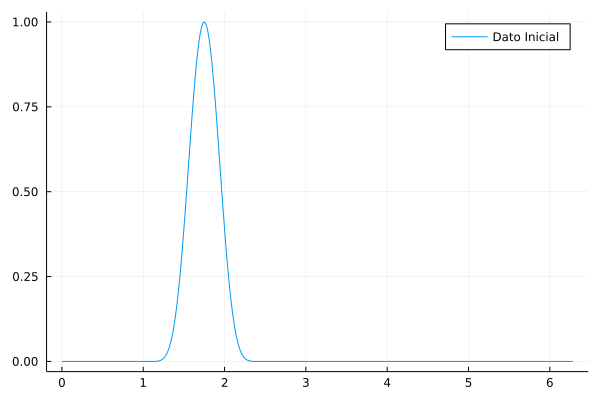

In [7]:
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                           #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
u0 = zeros(N)                          #Vector del dato inicial
x0=1.0
x1 = 2.5
p=8
for i in 1:N
    if x[i] > x0 && x[i] < x1
        u0[i] = (x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p)
    end
end

plot(x,u0, label = "Dato Inicial")

Parámetros de evolución

In [8]:
c = 1.0              #Velocidad de advección
function g(t, ω)     #Condición de borde en x=0. Puede cambiarla por lo que quiera!
    return exp(-(cos(t*ω)-1)^2)-1.0
end
T = 10.0 #tiempo final de evolución
ω = 3.0
p = (c, g, ω, dx)
h2, D_2_sbp = create_D_2_sbp(N);
#pmatricial = (h2[1,1], D_2_sbp, c, g, ω, dx)
dt = dx/c            #dt≈dx/VelocidadMax para estabilidad

0.01574733159694132

Ahora vamos a resolver el problema de dos formas distintas

In [9]:
#probmatricial = ODEProblem(F_sbp_matricial!,u0,(0.0,T),pmatricial);
prob = ODEProblem(F2_sbp!,u0,(0.0,T),p);

Y ahora resolvemos

In [10]:
#@time solmatricial = solve(probmatricial,RK4(),dt=dt, adaptive = false);

In [11]:
@time sol = solve(prob,RK4(),dt=dt, adaptive = false);

  5.978072 seconds (10.67 M allocations: 629.141 MiB, 2.19% gc time, 99.76% compilation time)


Finalmente graficamos las soluciones

┌ Info: Saved animation to 
│   fn = C:\Users\Usuario\Julia\De la especialidad\Tarea_3\advection_r.gif
└ @ Plots C:\Users\Usuario\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Usuario\\Julia\\De la especialidad\\Tarea_3\\advection_r.gif")
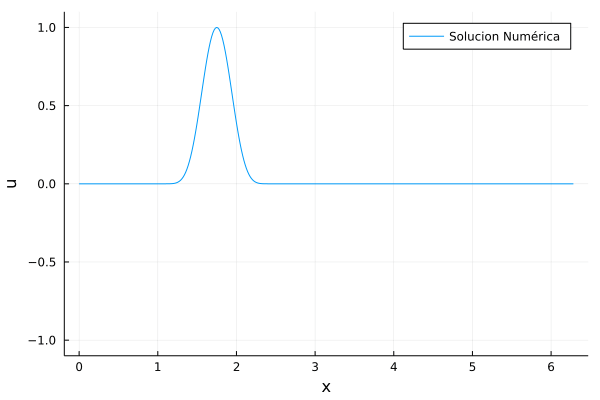

In [12]:
anim = @animate for t in sol.t[1:4:end]
    plot(x, sol(t), yaxis = ("u", (-1.1,1.1)), xlabel = "x", label = "Solucion Numérica")
    #plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "advection_r.gif", fps = 30)
    

### 2- Vea que la convergencia del método, en norma $L^2$, es de segundo orden, pese a que la aproximación en el borde es de primer orden.

In [13]:
function getsolution(N,order)

    dx = 2*pi/(N-1)                           #Δx
    x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
    u0 = zeros(N)                          #Vector del dato inicial
    x0=1.0
    x1 = 2.5
    p=8
    for i in 1:N
        if x[i] > x0 && x[i] < x1
            u0[i] = (x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p)
        end
    end
    
    
    
    c = 1.0              #Velocidad de advección
    function g(t, ω)     #Condición de borde en x=0. Puede cambiarla por lo que quiera!
        return (exp(-(cos(t*ω)-1)^2)-1.0)*0.2
    end
    T = 10.0 #tiempo final de evolución
    ω = 3.0
   
    
    if order == 2
        p = (c, g, ω, dx)
        h2, D_2_sbp = create_D_2_sbp(N);
        #pmatricial = (h2[1,1], D_2_sbp, c, g, ω, dx)
        dt = dx/c            #dt≈dx/VelocidadMax para estabilidad
    
        prob = ODEProblem(F2_sbp!,u0,(0.0,T),p);
        sol = solve(prob,RK4(),dt=dt, adaptive = false);
    end
    if order == 4
        h4, D_4_sbp = create_D_4_sbp(N);
        dt = 0.01*dx/c            #dt≈dx/VelocidadMax para estabilidad
    
        pmatricial = (h4[1,1], D_4_sbp, c, g, ω, dx)
        probmatricial = ODEProblem(F_sbp_matricial!,u0,(0.0,T),pmatricial);
        sol = solve(probmatricial,RK4(),dt=dt, adaptive = false);
    end
    return sol
end

function Energ(t,sol,h,D)
    u = sol(t)[:,1]
    n=length(u)
    dx = 2*pi/(n-1)
    return ((h * u)' * u +  (h * u)' * u) * dx / 2.0
end
function detQ(t,sol_un,sol_do,sol_tre,h,D)
    soldt = copy(sol_un(t)[:,1])
    sol2dt = copy(sol_do(t)[1:2:end,1])
    sol4dt = copy(sol_tre(t)[1:4:end,1])
    u=soldt-sol2dt
    v=sol2dt-sol4dt
    Q = sqrt(((h * u)' * u)/((h * v)' * v))
    #Q = sum(abs.(soldt-sol2dt)) / sum(abs.(sol2dt-sol4dt))
    return Q
end

detQ (generic function with 1 method)

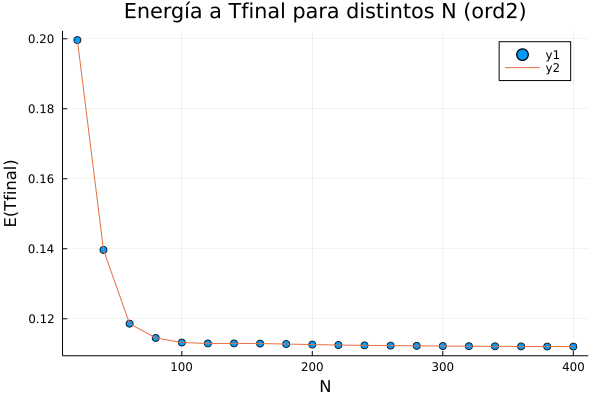

In [14]:
E=zeros(20)
for i in 1:20
    sol1=getsolution(i*20,2);
    h2, D_2_sbp = create_D_2_sbp(i*20);
    E[i]=Energ(9.0,sol1,h2, D_2_sbp)
end
enerp=plot()
scatter!(enerp,20*[1:20],E,title="Energía a Tfinal para distintos N (ord2)",xlabel="N",ylabel="E(Tfinal)")
plot!(enerp,20*[1:20],E)

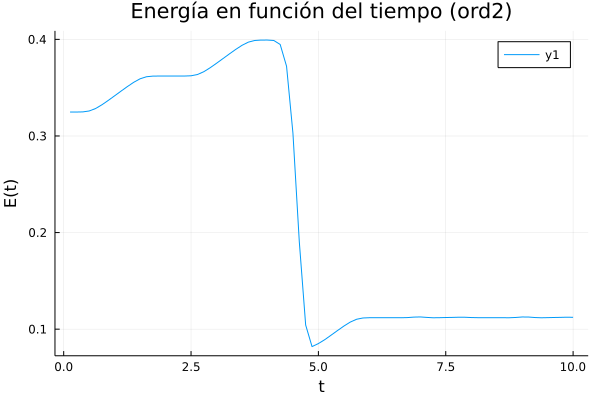

In [15]:
N=200
E=zeros(80)
sol1=getsolution(N,2);
h2, D_2_sbp = create_D_2_sbp(N);
for i in 1:80
    E[i]=Energ(i/8.0,sol1,h2, D_2_sbp)
end
enertp=plot()
plot!(enertp,1/8*[1:80],E,title="Energía en función del tiempo (ord2)",xlabel="t",ylabel="E(t)")

In [16]:
# recordando que dx = 2pi/(N-1) y dt = dx/c 
 
N=250
sol1=getsolution(N+1,2);
sol2=getsolution(2*N+1,2);
sol4=getsolution(4*N+1,2);

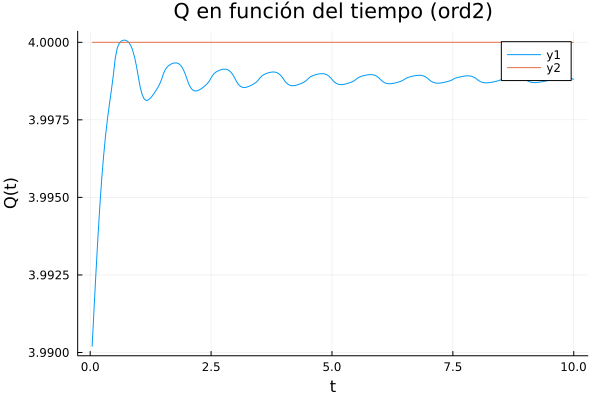

In [17]:
h2, D_2_sbp = create_D_2_sbp(N+1);
q=zeros(N+1)
for i in 1:N+1
    q[i]=detQ(2*pi/N*i*10.0/(N+1),sol1,sol2,sol4,h2, D_2_sbp) #recordar evaluar en tiempos que sean un entero por dt
end
qp=plot()
plot!(qp,10.0/(N+1)*[1:N+1],q,title="Q en función del tiempo (ord2)",xlabel="t",ylabel="Q(t)")
plot!(qp,10.0/(N+1)*[1:N+1],4.0*ones(N+1))

### 3- Contruya el operador de 4to orden y constate que converge, en norma $L^2$, en orden 4 (pese a que cerca del borde la convergencia baja a segundo orden). Constate que satisface suma por partes.

In [18]:
function create_D_4_sbp(N)
    D_4_sbp = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
    D_4_sbp[band(0)] .= 0.0
    D_4_sbp[band(1)] .= 2.0/3.0
    D_4_sbp[band(-1)] .= -2.0/3.0
    D_4_sbp[band(2)] .= -1.0/12.0
    D_4_sbp[band(-2)] .= 1.0/12.0
    
    D_4_sbp[1,1]=-24.0/17.0
    D_4_sbp[1,2]=59.0/34.0
    D_4_sbp[1,3]=-4.0/17.0
    D_4_sbp[1,4]=-3.0/34.0
    
    D_4_sbp[2,1]=-0.5
    D_4_sbp[2,2]=0
    D_4_sbp[2,3]=0.5
    D_4_sbp[2,4]=0
    
    D_4_sbp[3,1]=4.0/43.0
    D_4_sbp[3,2]=-59.0/86.0
    D_4_sbp[3,3]=0
    D_4_sbp[3,4]=59.0/86.0
    D_4_sbp[3,5]=-4.0/43.0
    
    D_4_sbp[4,1]=3.0/98.0
    D_4_sbp[4,2]=0
    D_4_sbp[4,3]=-59.0/98.0
    D_4_sbp[4,4]=0
    D_4_sbp[4,5]=32.0/49.0
    D_4_sbp[4,6]=-4.0/49.0
    
    D_4_sbp[end,end]=-D_4_sbp[1,1]
    D_4_sbp[end,end-1]=-D_4_sbp[1,2]
    D_4_sbp[end,end-2]=-D_4_sbp[1,3]
    D_4_sbp[end,end-3]=-D_4_sbp[1,4]
    
    D_4_sbp[end-1,end]=-D_4_sbp[2,1]
    D_4_sbp[end-1,end-1]=-D_4_sbp[2,2]
    D_4_sbp[end-1,end-2]=-D_4_sbp[2,3]
    D_4_sbp[end-1,end-3]=-D_4_sbp[2,4]
    
    D_4_sbp[end-2,end]=-D_4_sbp[3,1]
    D_4_sbp[end-2,end-1]=-D_4_sbp[3,2]
    D_4_sbp[end-2,end-2]=-D_4_sbp[3,3]
    D_4_sbp[end-2,end-3]=-D_4_sbp[3,4]
    D_4_sbp[end-2,end-4]=-D_4_sbp[3,5]
    
    D_4_sbp[end-3,end]=-D_4_sbp[4,1]
    D_4_sbp[end-3,end-1]=-D_4_sbp[4,2]
    D_4_sbp[end-3,end-2]=-D_4_sbp[4,3]
    D_4_sbp[end-3,end-3]=-D_4_sbp[4,4]
    D_4_sbp[end-3,end-4]=-D_4_sbp[4,5]
    D_4_sbp[end-3,end-5]=-D_4_sbp[4,6]
    
    D_4_sbp = sparse(D_4_sbp)
    dropzeros!(D_4_sbp)
    
    h4 = Diagonal([1. for i in 1:N])
    h4[1,1] = 17/48
    h4[2,2] = 59/48
    h4[3,3] = 43/48
    h4[4,4] = 49/48
    h4[end,end] = h4[1,1]
    h4[end-1,end-1] = h4[2,2]
    h4[end-2,end-2] = h4[3,3]
    h4[end-3,end-3] = h4[4,4]
    return h4, D_4_sbp
end

create_D_4_sbp (generic function with 1 method)

In [19]:
h4, D_4_sbp = create_D_4_sbp(8);
#Matriz del producto interno H
display(h4)
#Operador de derivada de segundo orden en el interior, primer orden en el borde
display(D_4_sbp)

8×8 Diagonal{Float64, Vector{Float64}}:
 0.354167   ⋅        ⋅         ⋅        ⋅        ⋅         ⋅        ⋅ 
  ⋅        1.22917   ⋅         ⋅        ⋅        ⋅         ⋅        ⋅ 
  ⋅         ⋅       0.895833   ⋅        ⋅        ⋅         ⋅        ⋅ 
  ⋅         ⋅        ⋅        1.02083   ⋅        ⋅         ⋅        ⋅ 
  ⋅         ⋅        ⋅         ⋅       1.02083   ⋅         ⋅        ⋅ 
  ⋅         ⋅        ⋅         ⋅        ⋅       0.895833   ⋅        ⋅ 
  ⋅         ⋅        ⋅         ⋅        ⋅        ⋅        1.22917   ⋅ 
  ⋅         ⋅        ⋅         ⋅        ⋅        ⋅         ⋅       0.354167

8×8 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
 -1.41176     1.73529   -0.235294   …    ⋅           ⋅          ⋅ 
 -0.5          ⋅         0.5             ⋅           ⋅          ⋅ 
  0.0930233  -0.686047    ⋅              ⋅           ⋅          ⋅ 
  0.0306122    ⋅        -0.602041      -0.0816327    ⋅          ⋅ 
   ⋅           ⋅         0.0816327      0.602041     ⋅        -0.0306122
   ⋅           ⋅          ⋅         …    ⋅          0.686047  -0.0930233
   ⋅           ⋅          ⋅            -0.5          ⋅         0.5
   ⋅           ⋅          ⋅             0.235294   -1.73529    1.41176

In [20]:
N = 200
h4, D_4_sbp = create_D_4_sbp(N);
u = rand(N) #Definimos algun u completamente aleatorio
v = rand(N) #Definimos algún v completamente aleatorio
#h(Dv)'u 
println("El siguiente número debe ser 0 (o un número ridículamente pequeño, cercano a 10^-16)")
println((h4 * (D_4_sbp * v))' * u +  (h4 * (D_4_sbp * u))' * v - (u[N]*v[N] - u[1]*v[1]))

El siguiente número debe ser 0 (o un número ridículamente pequeño, cercano a 10^-16)
5.551115123125783e-16


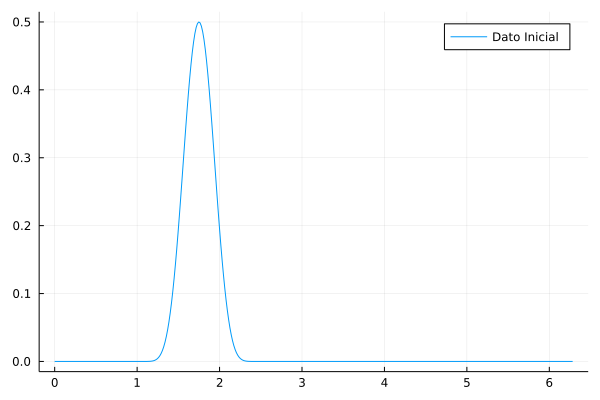

In [21]:
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                           #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
u0 = zeros(N)                          #Vector del dato inicial
x0=1.0
x1 = 2.5
p=8
for i in 1:N
    if x[i] > x0 && x[i] < x1
        u0[i] = ((x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p))/2.0
    end
end

plot(x,u0, label = "Dato Inicial")

In [22]:
c = 1.0              #Velocidad de advección
function gg(t, ω)     #Condición de borde en x=0. Puede cambiarla por lo que quiera!
    return exp(-(cos(t*ω)-1)^2)-1.0
end
T = 10.0 #tiempo final de evolución
ω = 3.0
p = (c, g, ω, dx)
h4, D_4_sbp = create_D_4_sbp(N);
pmatricial = (h4[1,1], D_4_sbp, c, g, ω, dx)
dt = dx/c            #dt≈dx/VelocidadMax para estabilidad

0.01574733159694132

In [23]:
probmatricial = ODEProblem(F_sbp_matricial!,u0,(0.0,T),pmatricial);
@time solmatricial = solve(probmatricial,RK4(),dt=dt, adaptive = false);

  1.436350 seconds (2.79 M allocations: 169.384 MiB, 13.28% gc time, 99.29% compilation time)


┌ Info: Saved animation to 
│   fn = C:\Users\Usuario\Julia\De la especialidad\Tarea_3\advection_r_order4.gif
└ @ Plots C:\Users\Usuario\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Usuario\\Julia\\De la especialidad\\Tarea_3\\advection_r_order4.gif")
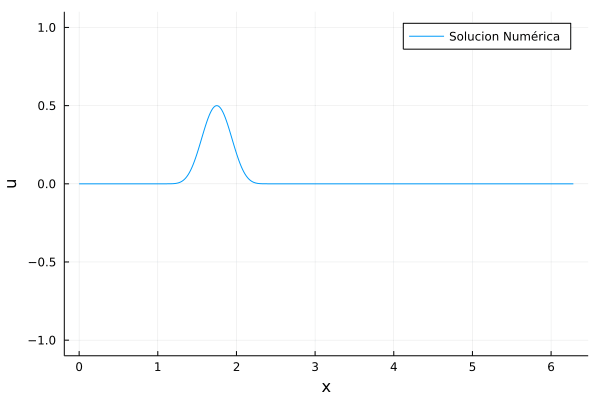

In [24]:
anim = @animate for t in solmatricial.t[1:4:end]
    plot(x, solmatricial(t), yaxis = ("u", (-1.1,1.1)), xlabel = "x", label = "Solucion Numérica")
    #plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "advection_r_order4.gif", fps = 30)
    

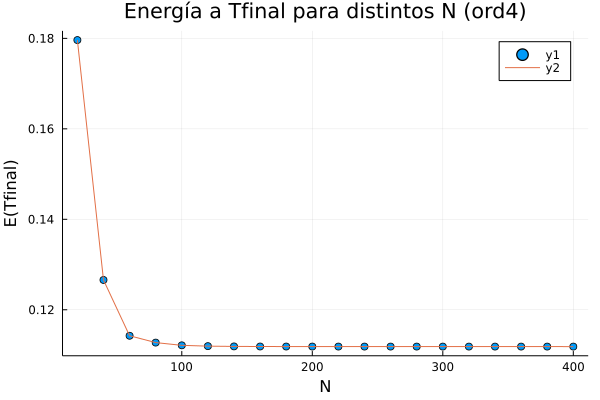

In [25]:
E=zeros(20)
for i in 1:20
    sol1=getsolution(i*20,4);
    h2, D_2_sbp = create_D_2_sbp(i*20);
    E[i]=Energ(9.0,sol1,h2, D_2_sbp)
end
enerp=plot()
scatter!(enerp,20*[1:20],E,title="Energía a Tfinal para distintos N (ord4)",xlabel="N",ylabel="E(Tfinal)")
plot!(enerp,20*[1:20],E)

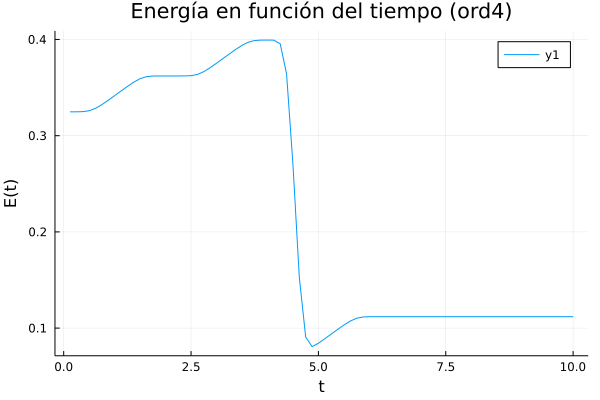

In [26]:
N=200
E=zeros(80)
sol1=getsolution(N,4);
h4, D_4_sbp = create_D_4_sbp(N);
for i in 1:80
    E[i]=Energ(i/8.0,sol1,h4, D_4_sbp)
end
enertp=plot()
plot!(enertp,1/8*[1:80],E,title="Energía en función del tiempo (ord4)",xlabel="t",ylabel="E(t)")

In [27]:
# recordando que dx = 2pi/(N-1) y dt = dx/c 

N=200
sol1=getsolution(N+1,4);
sol2=getsolution(2*N+1,4);
sol4=getsolution(4*N+1,4);

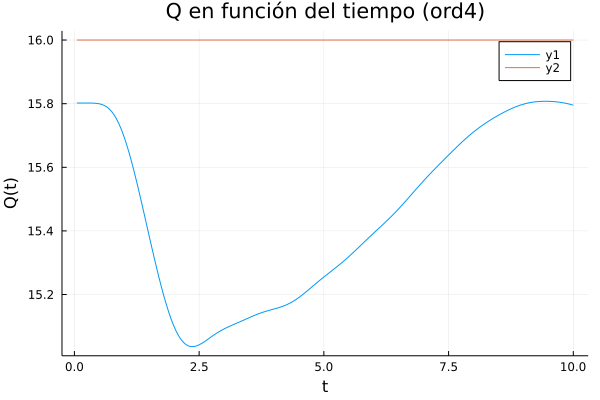

In [28]:
h4, D_4_sbp = create_D_4_sbp(N+1);
q=zeros(N+1)
for i in 1:N+1
    q[i]=detQ(2*pi/N*i*10.0/(N-1),sol1,sol2,sol4,h4, D_4_sbp) #recordar evaluar en tiempos que sean un entero por dt
end
qp2=plot()
plot!(qp2,10.0/(N+1)*[1:N+1],q,title="Q en función del tiempo (ord4)",xlabel="t",ylabel="Q(t)")
plot!(qp2,10.0/(N+1)*[1:N+1],16.0*ones(N+1))

### **4)** Considere ahora la ecuación de onda, $\phi_{tt} = c^2 \phi_{xx}$. Descompóngala en una ecuación ordinaria, un modo propagando hacia la izquierda y otro hacia la derecha. **Ayuda:** Vea que ecuación satisface la combinación $V_+ := \phi_t - c\phi_x$. Use esta descomposición para dar condiciones de contorno de forma que el problema quede completamente determinado (pero no sobredeterminado). Considere los siguientes casos: 
1. Condiciones de contorno nulas, nada entra, dato inicial no nulo.
2. Condiciones de contorno reflejantes, lo que llega por un modo entra por el otro. Para dar esta condición elija la combinación de modos en el borde de forma tal que $\phi$ se mantenga constante en el tiempo. 

### Primero voy a confirmar que puedo resolver advección en el sentido contrario

In [29]:
function F2_invers_sbp!(du,u,p,t)
    # second order version
    c, g, parg, dx = p
    #c -> velocidad de propagación (debe ser > 0)
    #g -> condición de borde
    #parg -> parámetros de g
    h = 1. /dx 
    hNN = 0.5 # -> componente NN de la matriz del producto interno.
    #Extremo izquierdo
    du[1] = -c*h*(u[2]-u[1])            #Derivada a primer orden que nos permite satisfacer SBP
    
    #resolvemos los puntos interiores
    #du[i] = c*(u[i+1]-u[i-1])/dx
    @. du[2:end-1] = -c*0.5*h*(u[3:end]-u[1:end-2])
    #Extremos derecho
    du[end] = -c*h*(u[end]-u[end-1]) - c*h/hNN*(g(t, parg) - u[end])    #SAT_N     #Derivada a primer orden que nos permite satisfacer SBP

end

F2_invers_sbp! (generic function with 1 method)

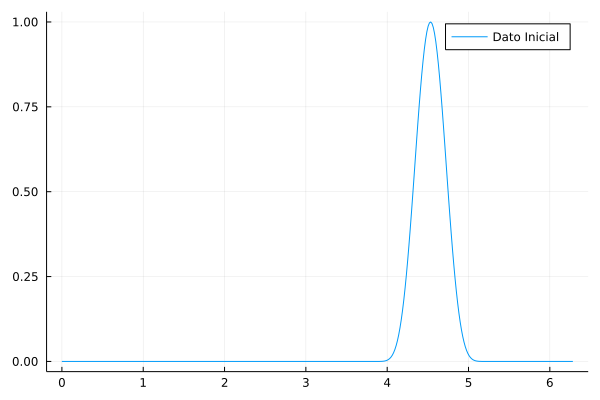

In [30]:
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                           #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
u0 = zeros(N)                          #Vector del dato inicial
x0=2*pi-2.5
x1 = 2*pi-1.0
p=8
for i in 1:N
    if x[i] > x0 && x[i] < x1
        u0[i] = (x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p)
    end
end

plot(x,u0, label = "Dato Inicial")

In [31]:
c = -1.0              #Velocidad de advección NEGATIVA

T = 10.0 #tiempo final de evolución
ω = 3.0
p = (c, gg, ω, dx)
h2, D_2_sbp = create_D_2_sbp(N);
#pmatricial = (h2[1,1], D_2_sbp, c, g, ω, dx)
dt = dx/c            #dt≈dx/VelocidadMax para estabilidad

probrever = ODEProblem(F2_invers_sbp!,u0,(0.0,T),p);

@time solrever = solve(probrever,RK4(),dt=dt, adaptive = false);

  1.295248 seconds (3.00 M allocations: 196.821 MiB, 99.03% compilation time)


┌ Info: Saved animation to 
│   fn = C:\Users\Usuario\Julia\De la especialidad\Tarea_3\advection_l.gif
└ @ Plots C:\Users\Usuario\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Usuario\\Julia\\De la especialidad\\Tarea_3\\advection_l.gif")
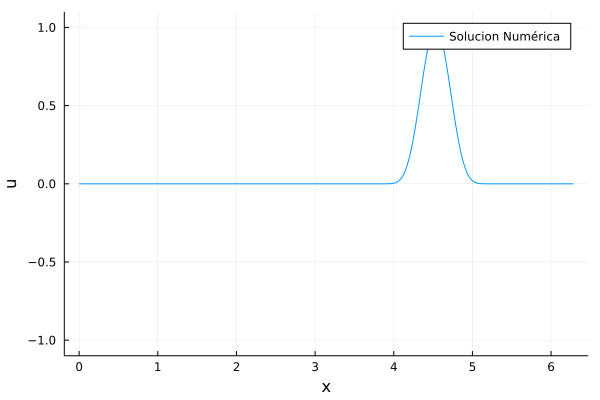

In [32]:
anim = @animate for t in sol.t[1:4:end]
    plot(x, solrever(t), yaxis = ("u", (-1.1,1.1)), xlabel = "x", label = "Solucion Numérica")
    #plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "advection_l.gif", fps = 30)

Ahora si:
1. Condiciones de contorno nulas, nada entra, dato inicial no nulo.

In [33]:
function F2_ondas_sbp!(dr,r,p,t)
    # second order version
    u = @view r[:,1]
    v = @view r[:,2]
    du = @view dr[:,1]
    dv = @view dr[:,2]
    c, g, parg, dx = p
    
    h = 1. /dx
    
    #u
    
    h11 = 0.5 
    
    du[1] = (-c*h*(u[2]-u[1]) + c*h/h11*(g(t, parg) - u[1]))   
    
    @. du[2:end-1] = -c*0.5*h*(u[3:end]-u[1:end-2])
    
    du[end] = -c*h*(u[end]-u[end-1])  
    
    #v
    
    hNN = 0.5 
    
    dv[1] = c*h*(v[2]-v[1])      
    
    @. dv[2:end-1] = c*0.5*h*(v[3:end]-v[1:end-2])
    
    dv[end] = c*h*(v[end]-v[end-1]) + c*h/hNN*(g(t, parg) - v[end])   

end

F2_ondas_sbp! (generic function with 1 method)

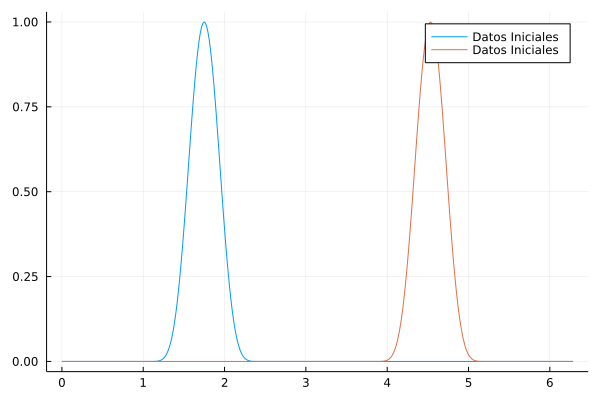

In [34]:
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                           #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
#Dato inicial para V+
r0=zeros(N,2)                          #Vector del dato inicial
u0 = @view r0[:,1]
v0 = @view r0[:,2]
x0=1.0
x1=2.5
p=8
for i in 1:N
    if x[i] > x0 && x[i] < x1
        u0[i] = (x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p)
    end
end
#Dato inicial para V-
x0r=2*pi-2.5
x1r = 2*pi-1.0
p=8
for i in 1:N
    if x[i] > x0r && x[i] < x1r
        v0[i] = (x[i] - x0r)^p * (x[i] - x1r)^p / (0.5*(x1r-x0r))^(2p)
    end
end

plot(x,r0, label = "Datos Iniciales")

In [ ]:
c = 1.0              #Velocidad de advección
function hmg(t, ω)     #Condición de borde en borde. Puede cambiarla por lo que quiera!
    return 0.
end
T = 10.0 #tiempo final de evolución
ω = 3.0
p = (c, hmg, ω, dx)
h2, D_2_sbp = create_D_2_sbp(N);
#pmatricial = (h2[1,1], D_2_sbp, c, g, ω, dx)
dt = dx/c            #dt≈dx/VelocidadMax para estabilidad

prob = ODEProblem(F2_ondas_sbp!,r0,(0.0,T),p);

@time sol = solve(prob,RK4(),dt=dt, adaptive = false);


In [ ]:
anim = @animate for t in sol.t[1:4:end]
    plot(x, 0.5*(sol(t)[:,1]+sol(t)[:,2]), yaxis = ("u", (-1.1,1.1)), xlabel = "x", label = "Solucion Numérica")
    #plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "waves_hmg_boundary.gif", fps = 30)

In [ ]:
function F2_refleja_sbp!(dr,r,p,t)
    # second order version
    u = @view r[:,1]
    v = @view r[:,2]
    du = @view dr[:,1]
    dv = @view dr[:,2]
    c, g, parg, dx = p
    
    h = 1. /dx
    
    #u
    
    h11 = 0.5 
    
    du[1] = (-c*h*(u[2]-u[1]) + c*h/h11*(-v[1] - u[1]))   
    
    @. du[2:end-1] = -c*0.5*h*(u[3:end]-u[1:end-2])
    
    du[end] = -c*h*(u[end]-u[end-1])  
    
    #v
    
    hNN = 0.5 
    
    dv[1] = c*h*(v[2]-v[1])      
    
    @. dv[2:end-1] = c*0.5*h*(v[3:end]-v[1:end-2])
    
    dv[end] = c*h*(v[end]-v[end-1]) + c*h/hNN*(-u[end] - v[end])   

end

In [ ]:
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                           #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
#Dato inicial para V+
r0=zeros(N,2)                          #Vector del dato inicial
u0 = @view r0[:,1]
v0 = @view r0[:,2]
x0=1.0
x1=2.5
p=8
for i in 1:N
    if x[i] > x0 && x[i] < x1
        u0[i] = (x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p)
    end
end

x0r=2*pi-2.5
x1r = 2*pi-1.0
p=8
for i in 1:N
    if x[i] > x0r && x[i] < x1r
        v0[i] = (x[i] - x0r)^p * (x[i] - x1r)^p / (0.5*(x1r-x0r))^(2p)
    end
end

c = 1.0              #Velocidad de advección

T = 10.0 #tiempo final de evolución
ω = 3.0
p = (c, hmg, ω, dx)
h2, D_2_sbp = create_D_2_sbp(N);
#pmatricial = (h2[1,1], D_2_sbp, c, g, ω, dx)
dt = dx/c            #dt≈dx/VelocidadMax para estabilidad

prob = ODEProblem(F2_refleja_sbp!,r0,(0.0,T),p);

@time sol = solve(prob,RK4(),dt=dt, adaptive = false);


In [ ]:
anim = @animate for t in sol.t[1:4:end]
    plot(x, 0.5*(sol(t)[:,1]+sol(t)[:,2]), yaxis = ("u", (-1.1,1.1)), xlabel = "x", label = "Solucion Numérica")
    #plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "wave_refl_boundary.gif", fps = 30)

## Podemos agregar también condiciones de borde en un lado, y reflectivas de otro

In [ ]:
function F2_refleja2_sbp!(dr,r,p,t)
    # second order version
    u = @view r[:,1]
    v = @view r[:,2]
    du = @view dr[:,1]
    dv = @view dr[:,2]
    c, g, parg, dx = p
    
    h = 1. /dx
    
    #u
    
    h11 = 0.5 
    
    du[1] = (-c*h*(u[2]-u[1]) + c*h/h11*(-v[1] - u[1]))   
    
    @. du[2:end-1] = -c*0.5*h*(u[3:end]-u[1:end-2])
    
    du[end] = -c*h*(u[end]-u[end-1])  
    
    #v
    
    hNN = 0.5 
    
    dv[1] = c*h*(v[2]-v[1])      
    
    @. dv[2:end-1] = c*0.5*h*(v[3:end]-v[1:end-2])
    
    dv[end] = c*h*(v[end]-v[end-1]) + c*h/hNN*(2*g(t, parg) - v[end])   

end

In [ ]:
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                           #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
#Dato inicial para V+
r0=zeros(N,2)                          #Vector del dato inicial
u0 = @view r0[:,1]
v0 = @view r0[:,2]


c = 1.0              #Velocidad de advección
function co(t, ω)     #Condición de borde en x=0. Puede cambiarla por lo que quiera!
    return 0.3*sin(t*ω)
end
T = 20.0 #tiempo final de evolución
ω = 3.0
p = (c, co, ω, dx)
h2, D_2_sbp = create_D_2_sbp(N);
#pmatricial = (h2[1,1], D_2_sbp, c, g, ω, dx)
dt = dx/c            #dt≈dx/VelocidadMax para estabilidad

prob = ODEProblem(F2_refleja2_sbp!,r0,(0.0,T),p);

@time sol = solve(prob,RK4(),dt=dt, adaptive = false);


In [ ]:
anim = @animate for t in sol.t[1:4:end]
    plot(x, 0.5*(sol(t)[:,1]+sol(t)[:,2]), yaxis = ("u", (-1.1,1.1)), xlabel = "x", label = "Solucion Numérica")
    #plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "standing_wave.gif", fps = 30)